# Data Overview
* Data of Retail Transaction from 01 December 2010 to 09 December 2011
* Source Data: Online retail dataset by UCI Machine Learning Library. https://archive.ics.uci.edu/ml/datasets/Online+Retail
* InvoiceNo: Invoice number uniquely assigned to each transaction.
* StockCode: Product (item) code.
* Description: Product (item) name.
* Quantity: The quantities of each product (item) per transaction.
* InvoiceDate: The day and time when each transaction was generated.
* UnitPrice: Product price per unit in sterling.
* CustomerID: Customer number uniquely assigned to each customer.
* Country: The name of the country where each customer resides.

# Data preparation
* Python Version: 3.7.6
* Packages: Pandas, Numpy, Matplotlib, Seaborn, Sklearn, and Feature Engine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import plotly.offline as pyoff
import plotly.graph_objs as go

import feature_engine
from feature_engine.outliers import Winsorizer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
#Check Dataset

df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

* The min value for Quantity is -80995 which could represent cancelled or returned orders.
* The UnitPrice also has a few negative values which is uncommon but could represent cancelled orders by customers or bad-debt incurred by the business.
* Bad debt adjustments will be dropped from the dataset as these do not represent actual sales.
* We need to clean the above values by removing from the dataset.

In [6]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are roughly 25% missing CustomerID. We will be excluding these records from our analysis

In [8]:
#Country

df.Country.value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

We can see that there is maximum proportion (More than 90% of customers) of 'United Kingdom' customers. So we will take 'United Kingdom' customer for our analysis.

In [9]:
df = df[df.Country == 'United Kingdom']

Removing the negative values from Quantity and UnitPrice

In [10]:
#Quantity

df = df[df.Quantity > 0]

In [11]:
#InvoiceDate

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [16]:
#timebound

print(df["InvoiceDate"].min())
print(df["InvoiceDate"].max())

2010-12-01 08:26:00
2011-12-09 12:49:00


In [17]:
#UnitPrice

df = df[df.UnitPrice > 0]

In [18]:
#CustomerID

df = df[pd.notnull(df['CustomerID'])]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         354321 non-null  object        
 1   StockCode         354321 non-null  object        
 2   Description       354321 non-null  object        
 3   Quantity          354321 non-null  int64         
 4   InvoiceDate       354321 non-null  datetime64[ns]
 5   UnitPrice         354321 non-null  float64       
 6   CustomerID        354321 non-null  float64       
 7   Country           354321 non-null  object        
 8   InvoiceYearMonth  354321 non-null  int64         
 9   Date              354321 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 29.7+ MB


# Exploratory Data Analysis (Products sold every month)

In [20]:
#Aggregating the Orders by Month

df_agg= df.groupby("Date").Quantity.sum()
df_agg.head()

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
Name: Quantity, dtype: int64

In [21]:
#converting series to dataframe and resetting index.

df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

Date  Quantity
0  2010-12    267767
1  2011-01    278251
2  2011-02    213375
3  2011-03    276304
4  2011-04    260448

In [22]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Quantity', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

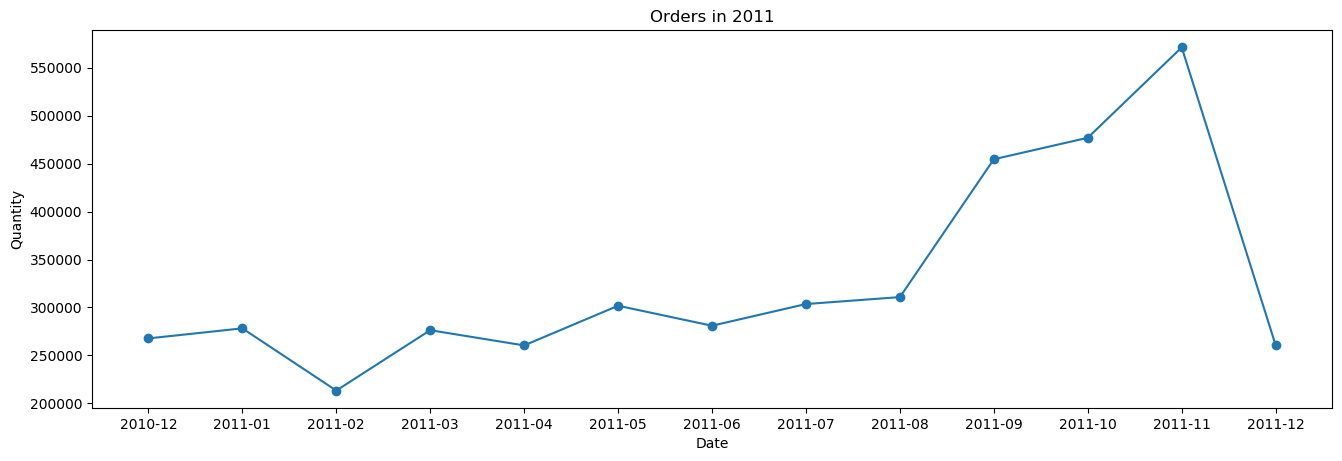

In [23]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Orders in 2011')

* Amount spent by customers every month

In [24]:
#Calculating Revenue
#Revenue = Order Count * Average Revenue per Order

df['Revenue'] = df['Quantity']*df['UnitPrice']

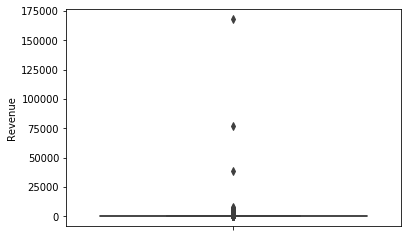

In [25]:
sns.boxplot(y=df['Revenue'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         354321 non-null  object        
 1   StockCode         354321 non-null  object        
 2   Description       354321 non-null  object        
 3   Quantity          354321 non-null  int64         
 4   InvoiceDate       354321 non-null  datetime64[ns]
 5   UnitPrice         354321 non-null  float64       
 6   CustomerID        354321 non-null  float64       
 7   Country           354321 non-null  object        
 8   InvoiceYearMonth  354321 non-null  int64         
 9   Date              354321 non-null  object        
 10  Revenue           354321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 32.4+ MB


In [27]:
#Monthly Revenue

df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.head()

InvoiceYearMonth     Revenue
0            201012  498661.850
1            201101  442190.060
2            201102  355655.630
3            201103  467198.590
4            201104  409559.141

In [28]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# RFM Analysis
* Recency Frequency Monetary (RFM) - RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.
* Recency — how long it’s been since a customer bought something from us.
* Frequency — how often a customer buys from us.
* Monetary value — the total value of purchases a customer has made.
* The last invoice date is 2011–12–09, we will use this date to calculate Recency.

In [29]:
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [30]:
#Recency

df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

CustomerID  Recency
0     12346.0      325
1     12747.0        2
2     12748.0        0
3     12749.0        3
4     12820.0        3

In [31]:
#Frequency - Monetarty

FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

Frequency  Monetary
CustomerID                     
12346.0             1  77183.60
12747.0           103   4196.01
12748.0          4595  33719.73
12749.0           199   4090.88
12820.0            59    942.34

In [32]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12747.0        2        103   4196.01
2     12748.0        0       4595  33719.73
3     12749.0        3        199   4090.88
4     12820.0        3         59    942.34

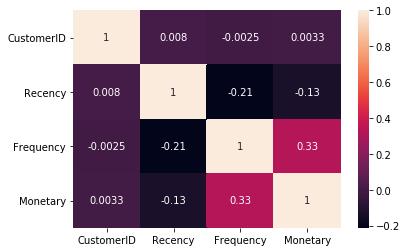

In [33]:
#Heatmap check
sns.heatmap(RFM_Table.corr(), annot=True);

# Modeling Data: RFM Quantiles
* Now we split the metrics into segments using quantiles.
* We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively.
* 1 is the highest value, and 4 is the lowest value.
* A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.


In [34]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [35]:
segmented_rfm = RFM_Table.copy()

In [36]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [37]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

CustomerID  Recency  Frequency  Monetary  R_quartile  F_quartile  \
0     12346.0      325          1  77183.60           4           4   
1     12747.0        2        103   4196.01           1           1   
2     12748.0        0       4595  33719.73           1           1   
3     12749.0        3        199   4090.88           1           1   
4     12820.0        3         59    942.34           1           2   

   M_quartile  
0           1  
1           1  
2           1  
3           1  
4           2

In [38]:
# RFM_Score = R_quartile + F_quartile + M_quartile
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [39]:
segmented_rfm.head()

CustomerID  Recency  Frequency  Monetary  R_quartile  F_quartile  \
0     12346.0      325          1  77183.60           4           4   
1     12747.0        2        103   4196.01           1           1   
2     12748.0        0       4595  33719.73           1           1   
3     12749.0        3        199   4090.88           1           1   
4     12820.0        3         59    942.34           1           2   

   M_quartile RFM_Segment  
0           1         441  
1           1         111  
2           1         111  
3           1         111  
4           2         122

In [40]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [41]:
segmented_rfm.head()

CustomerID  Recency  Frequency  Monetary  R_quartile  F_quartile  \
0     12346.0      325          1  77183.60           4           4   
1     12747.0        2        103   4196.01           1           1   
2     12748.0        0       4595  33719.73           1           1   
3     12749.0        3        199   4090.88           1           1   
4     12820.0        3         59    942.34           1           2   

   M_quartile RFM_Segment  RFM_Score  
0           1         441          9  
1           1         111          3  
2           1         111          3  
3           1         111          3  
4           2         122          5

In [42]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


In [43]:
# Setting up the label for each client and adding the column "Label" to the dataframe

label = [0] * len(segmented_rfm)

for i in range(0,len(segmented_rfm)):

    if segmented_rfm['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"
        
    elif segmented_rfm['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"
        
    elif segmented_rfm['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"
    
    elif segmented_rfm['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif segmented_rfm['F_quartile'][i] == 1:
        label[i] = "Loyal Customers"  
    
    elif segmented_rfm['M_quartile'][i] == 1:
        label[i] = "Big Spenders"   
        
    else:
        label[i] = "Others"

In [44]:
# Adding the 'Label' column to our dataframe

segmented_rfm['Label'] = label

In [45]:
# Adding the 'Label' column to our dataframe

segmented_rfm['Label'] = label

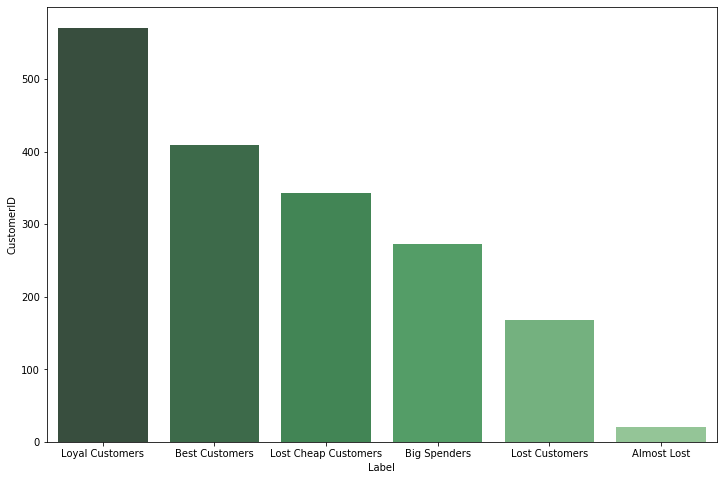

In [46]:
import seaborn as sns
sq1=segmented_rfm.groupby('Label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sq1.drop([0],inplace=True)
sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");

In [47]:
# Modeling Data: K-Means Clustering
K-Means clustering algorithm is an unsupervised machine learning algorithm that uses multiple iterations to segment the unlabeled data points into K different clusters in a way such that each data point belongs to only a single group that has similar properties.

SyntaxError: invalid syntax (<ipython-input-47-236e671cdb66>, line 2)

In [48]:
RFM_Table_New = RFM_Table.drop('CustomerID', axis=1)

In [49]:
RFM_Table_New.head()

Recency  Frequency  Monetary
0      325          1  77183.60
1        2        103   4196.01
2        0       4595  33719.73
3        3        199   4090.88
4        3         59    942.34

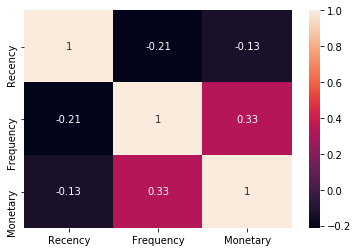

In [50]:
#Heatmap check
sns.heatmap(RFM_Table_New.corr(), annot=True);

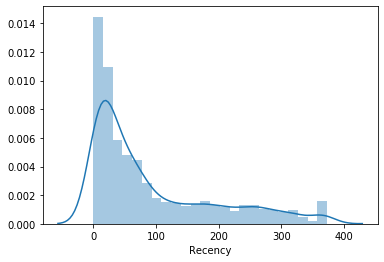

In [51]:
#Analyze distribution

sns.distplot(RFM_Table_New['Recency'])

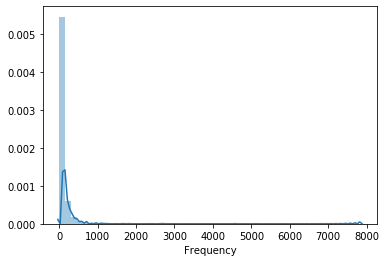

In [52]:
sns.distplot(RFM_Table_New['Frequency'])

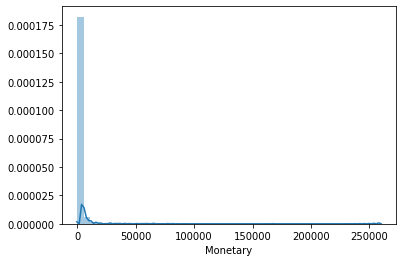

In [53]:
sns.distplot(RFM_Table_New['Monetary'])

K-means gives the best result under the following conditions:
* Data’s distribution is not skewed.
* Data is standardised.
The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.

In [54]:
df_rfm_log = RFM_Table_New.copy()
df_rfm_log.head()

Recency  Frequency  Monetary
0      325          1  77183.60
1        2        103   4196.01
2        0       4595  33719.73
3        3        199   4090.88
4        3         59    942.34

In [55]:
df_rfm_log = np.log(df_rfm_log+1)

In [56]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [57]:
df_rfm_log = windsoriser.transform(df_rfm_log)

Once the skewness is reduced, the data is standardised by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [58]:
#Developing preprocessing with StandardScaler

scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_New_scaled = scaler.transform(df_rfm_log)

In [59]:
RFM_Table_New_scaled = pd.DataFrame(RFM_Table_New_scaled, columns=RFM_Table_New.columns)
RFM_Table_New_scaled.head()

Recency  Frequency  Monetary
0  1.465297  -2.075758  2.144403
1 -2.017919   0.758484  1.551824
2 -2.065875   2.073202  2.144403
3 -1.804182   1.296742  1.530081
4 -1.804182   0.305732  0.272393

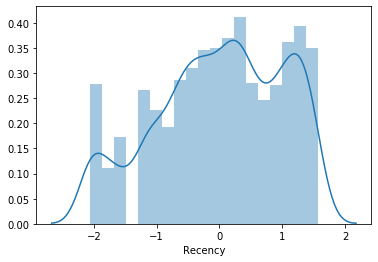

In [60]:
#Analyze distribution

sns.distplot(RFM_Table_New_scaled['Recency'])


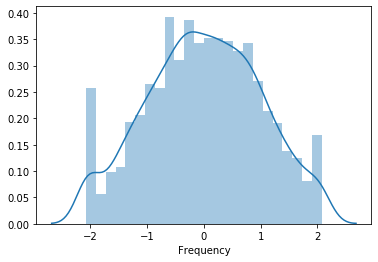

In [61]:
sns.distplot(RFM_Table_New_scaled['Frequency'])

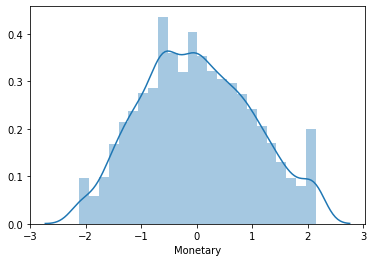

In [62]:
sns.distplot(RFM_Table_New_scaled['Monetary'])

In [63]:
#Finding the optimal number of clusters
X = np.asarray(RFM_Table_New_scaled)

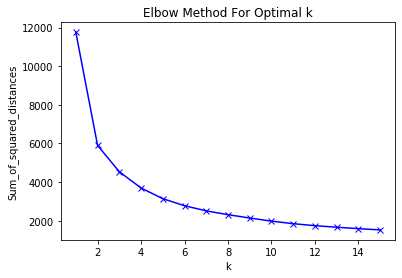

In [64]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

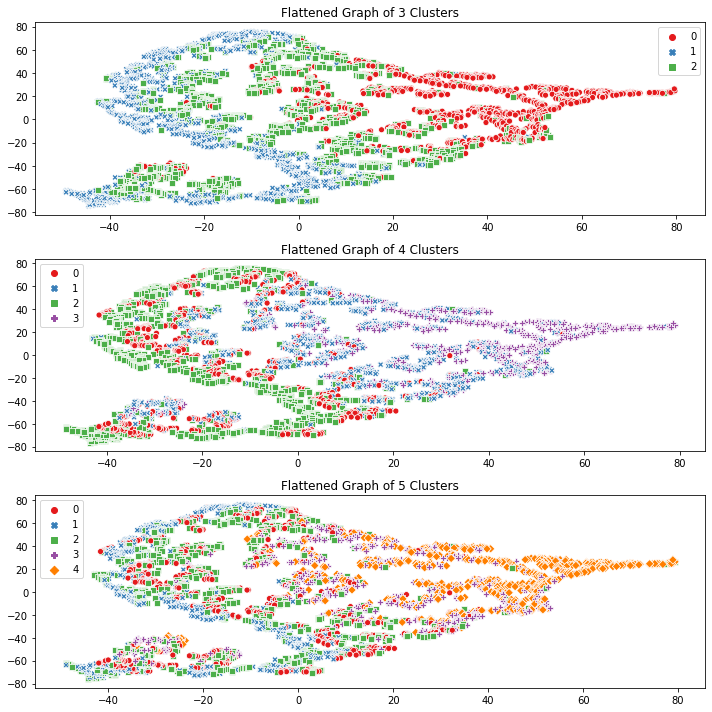

In [66]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_New_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_New_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_New_scaled, 5, RFM_Table)

plt.tight_layout()

In [67]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

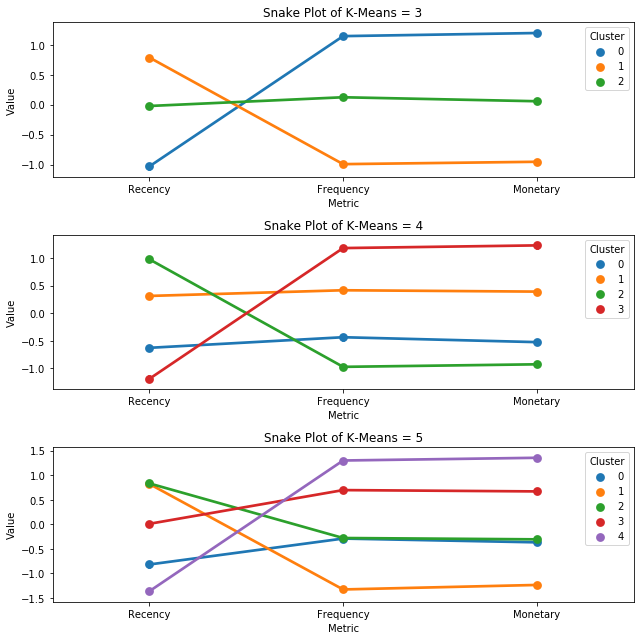

In [68]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_New_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_New_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_New_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

In [69]:
# Evaluating Model: K-Means Clustering
* Davies Bouldin Score is a metric for evaluating clustering algorithms. The smaller Davies Bouldin Score is The more optimal the cluster.
* K-Means = 3

SyntaxError: invalid syntax (<ipython-input-69-a225a8e266a3>, line 2)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

In [ ]:
print(davies_bouldin_score(X, kmeans.labels_))

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

In [ ]:
print(davies_bouldin_score(X, kmeans.labels_))

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

In [ ]:
print(davies_bouldin_score(X, kmeans.labels_))

In [ ]:
df_rfm_k4.head()

In [ ]:
df_rfm_k4.Cluster.value_counts()

In [ ]:
import seaborn as sns
sq1=df_rfm_k4.groupby('Cluster')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(data=sq1, x="Cluster", y="CustomerID", palette = "Greens_d");

In [ ]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)    
    return df_new

In [ ]:
rfm_values(df_rfm_k4)

* "Cluster 0" has 29% customers. It belongs to the "Loyal Customers" segment as they Haven’t purchased for some time, but used to purchase frequently (F=2) and usually spend a lot. (R=3, F=2, M=2)
* "Cluster 1" has 20% customers. It can be interpreted as "Alomost Lost". They made purchases recently (R=2). However they do not purchase frequently and do not spend a lot. (R=2, F=3, M=3)
* "Cluster 2" has 30% customers. It can be interpreted as "Lost Cheap Customers". Their last purchase is long ago (R=4), purchased very few (F=4) and spend a little (M=4). (R=4, F=4, M=4)
* "Cluster 3" has 21% customers. It belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spend the most (M=1). (R=1, F=1, M=1)

# Recommendation
* Recommendation for “Best Customers" segment: Focus on increasing customer purchases therefore it is necessary to form a cross/Up Selling Strategy.
* Recommendation for “Loyal Customers" segment: The business team must optimize the budget campaign and the time campaign for this customer segment in order to maintain their loyalty and increase their value.
* Recommendation for “Almost Lost" segment: This customer segment is very at risk for churn, so focus on activating customers and making repurchases by forming a Reactivation Strategy, Retention Strategy.
* Recommendation for “Lost Cheap Customers" segment: This customer segment has churned, so the focus of the campaign is to reactivate the customer by forming a Reactivation strategy.